# Using optimization model to fit for experimental data

In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from models import TransferFunctionModel
from back_prop_utils import H_th_function, round_to_sig_figs
from loss_functions import loss
from plotting_utils import plot_transfer, plot_comparison, plot_loss_contributions

In [2]:
## Move file directory to import Extractor for signal manipulation
# Save the original sys.path
original_sys_path = sys.path.copy()

try:
    # Move two levels up to THz-TDS and add it to sys.path
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

    # Now import Extractor
    from Extraction.Extractor import Extractor

finally:
    # Restore sys.path to its original state
    sys.path = original_sys_path

In [3]:
# Define file paths within THz-TDS repo
ref_path = "../../Data_sets/simple_data/ref.pulse.csv"
sample_path = "../../Data_sets/simple_data/Si.pulse.csv"

# Load data 
ref = pd.read_csv(ref_path).to_numpy()
sample = pd.read_csv(sample_path).to_numpy()

In [4]:
print("Reference shape:", ref.shape)
print("Sample shape:", sample.shape)

Reference shape: (701, 2)
Sample shape: (701, 2)


In [5]:
extractor = Extractor(ref, sample, thickness=3*1e-3)

Reference:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -37.46477718688622
Mean squared error:  0.0671512209065479
(Should be ~< 1.)
--------------------
Sample:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -192.24418598426507
Mean squared error:  0.06413903301303736
(Should be ~< 1.)
--------------------
Transfer function:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -154.77940879737844
Mean squared error:  6.112181585650803e-05
(Should be ~< 1.)
--------------------


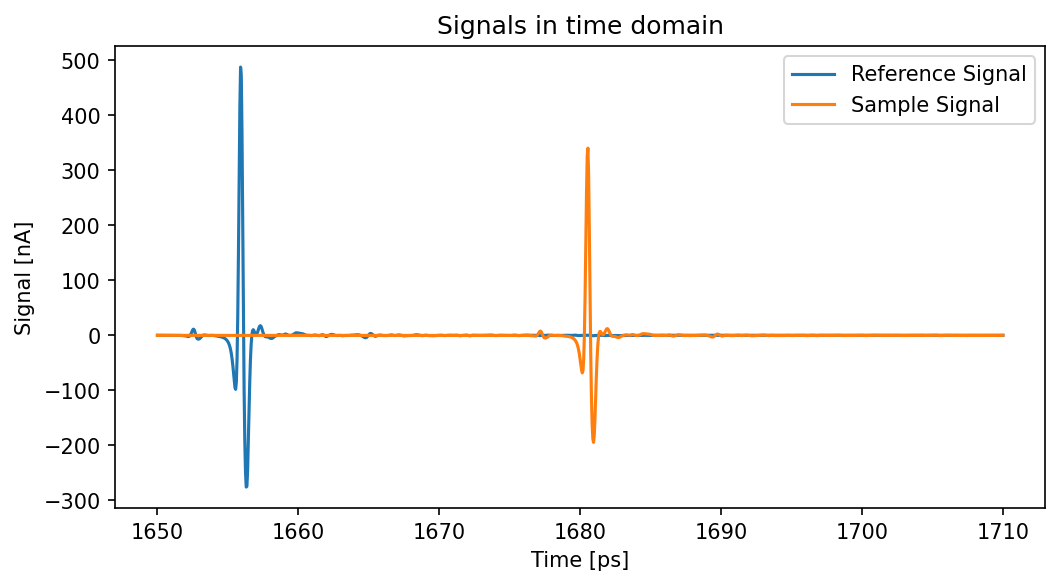

In [6]:
extractor.plot_time_domain()

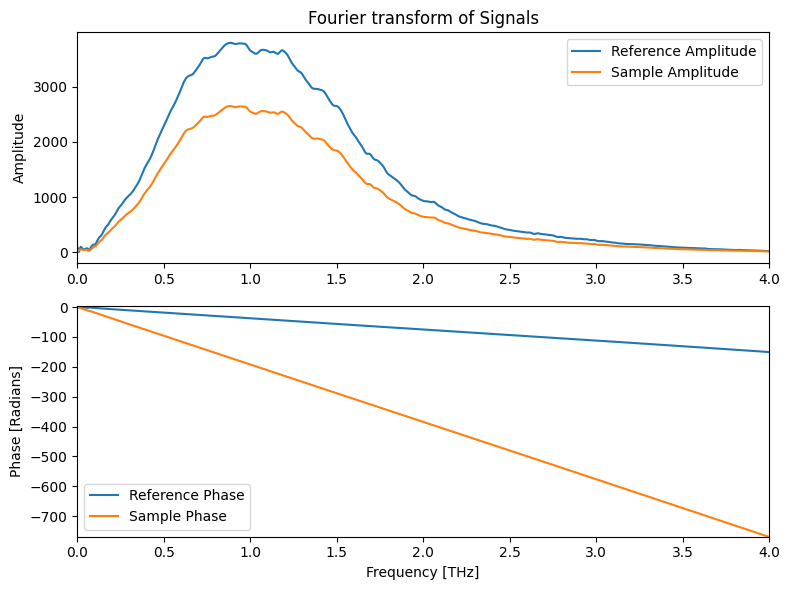

In [7]:
extractor.plot_frequency_domain(x_lims=[0,4])

In [8]:
df = extractor.get_fft_data()

In [9]:
df

,interpolated frequency,amplitude_signal_ref,amplitude_signal_sample,phase_signal_ref,phase_signal_sample,amplitude_transfer,phase_transfer
0,0.000000,95.148531,15.572690,-0.429684,2.716322,0.163667,-3.137179
1,0.004880,69.694027,23.909452,-1.262713,0.623413,0.343063,-4.397059
2,0.009760,6.948951,37.244900,-1.993110,-0.880350,5.359788,-5.170426
3,0.014640,60.338845,47.704227,0.215530,-2.192593,0.790606,-2.408124
4,0.019520,98.849323,53.157152,-0.549669,-3.419308,0.537759,-2.869639
...,...,...,...,...,...,...,...
4091,19.963827,94.167196,53.476666,-2179.898373,-5123.353733,0.567891,-2956.021730
4092,19.968707,98.849323,53.157152,-2180.575001,-5124.510444,0.537759,-2956.501814
4093,19.973587,60.338845,47.704227,-2181.340200,-5125.737159,0.790606,-2956.963329
4094,19.978467,6.948951,37.244900,-2179.131560,-5127.049402,5.359788,-2954.201027


In [10]:
# Define frequency range we are interested in.
freqs_range = [0.3, 2]

freqs_THz = df['interpolated frequency']

# Find the closest available values within the range
lower_bound = freqs_THz[freqs_THz >= freqs_range[0]].min()
upper_bound = freqs_THz[freqs_THz <= freqs_range[1]].max()

# Apply the boundaries
# Ensure df['frequency'] exists and corresponds to freqs_THz
df_filtered = df[(df['interpolated frequency'] >= lower_bound) & (df['interpolated frequency'] <= upper_bound)]
freqs_THz = freqs_THz[(freqs_THz >= lower_bound) & (freqs_THz <= upper_bound)]

H_values = df_filtered['amplitude_transfer']
phi_values = df_filtered['phase_transfer']

In [11]:
type(phi_values)

pandas.core.series.Series

In [12]:
# Find the offset value of phase to align during loss 
phase_offset = phi_values.iloc[0]

phi_values = phi_values - phase_offset

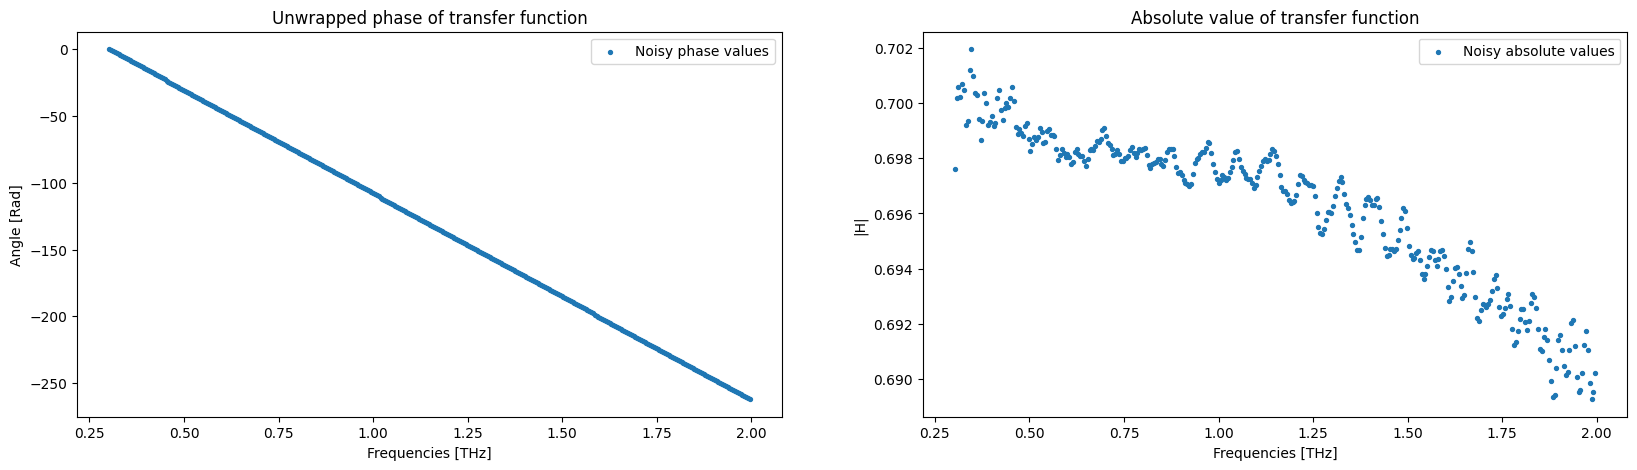

In [13]:
plot_transfer(freqs_THz, H_values, phi_values)

In [14]:
min(freqs_THz), max(freqs_THz)

(0.30255617266469104, 1.9958947519332035)

Epoch 0: Total Loss = 108.44208526611328, Learning Rate = 0.0001
Epoch 500: Total Loss = 89.57279205322266, Learning Rate = 0.0001
Epoch 1000: Total Loss = 78.5362548828125, Learning Rate = 0.0001
Epoch 1500: Total Loss = 72.30139923095703, Learning Rate = 0.0001
Epoch 2000: Total Loss = 69.07109069824219, Learning Rate = 1.0000000000000002e-06
Epoch 2500: Total Loss = 69.01424407958984, Learning Rate = 1.0000000000000004e-08
Epoch 3000: Total Loss = 69.01424407958984, Learning Rate = 1.0000000000000004e-08
Epoch 3500: Total Loss = 69.01424407958984, Learning Rate = 1.0000000000000004e-08
Epoch 4000: Total Loss = 69.01424407958984, Learning Rate = 1.0000000000000004e-08
Epoch 4500: Total Loss = 69.01424407958984, Learning Rate = 1.0000000000000004e-08
Epoch 5000: Total Loss = 69.01424407958984, Learning Rate = 1.0000000000000004e-08
Epoch 5500: Total Loss = 69.01424407958984, Learning Rate = 1.0000000000000004e-08
Epoch 6000: Total Loss = 69.01424407958984, Learning Rate = 1.0000000000

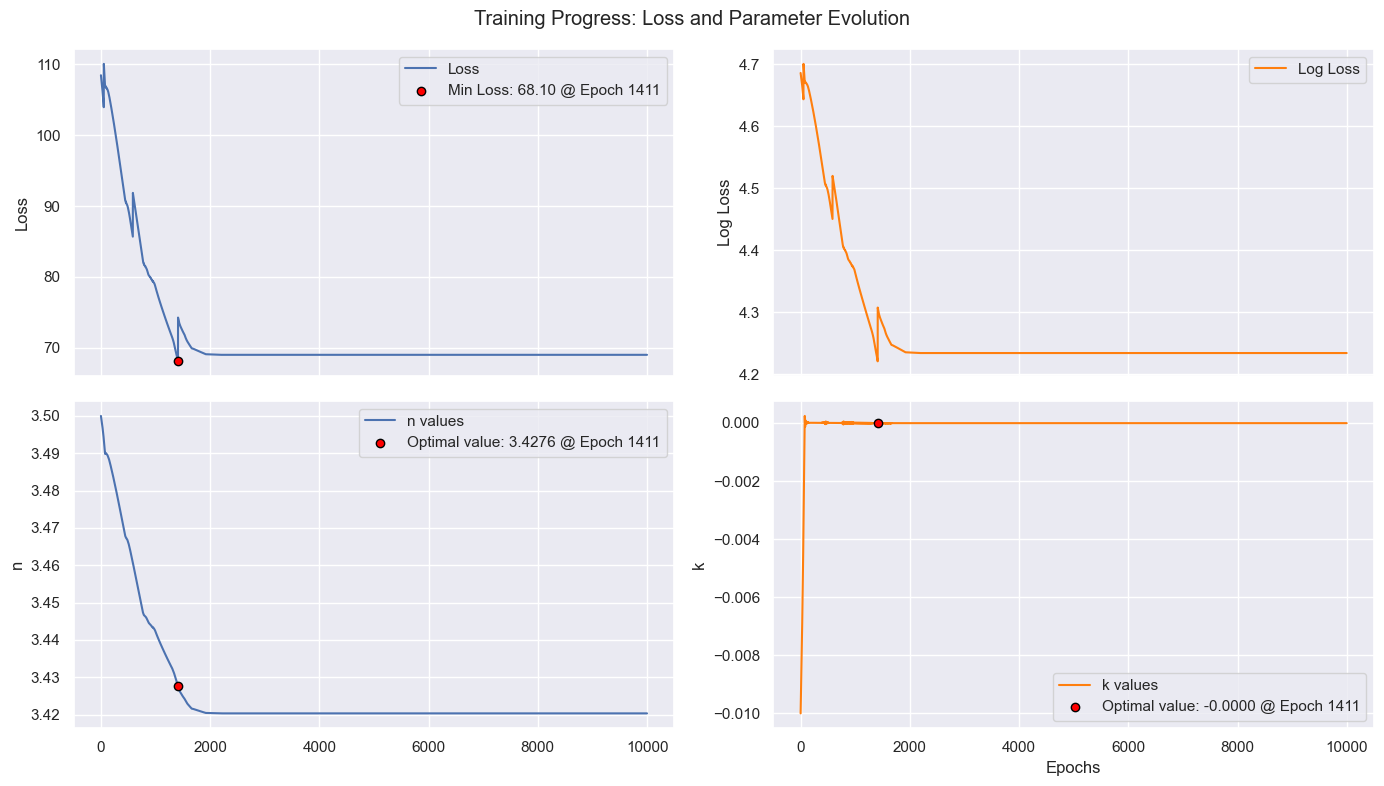

In [15]:
## Use model to fit the experimental data
thickness = 3*1e-3
f = freqs_THz.to_numpy()
# Convert f_tensor to angular freqs with correct scale for predictions
f = f * (1 * 10e12)
w_tensor = f * np.pi * 2

# Convert correct values to tensor
w_tensor = torch.tensor(w_tensor, dtype=torch.float32)
H_values = torch.tensor(H_values.to_numpy(), dtype=torch.float32)
phi_values = torch.tensor(phi_values.to_numpy(), dtype=torch.float32)

# Initialize model for frequency range, thickness and initial conditions
model = TransferFunctionModel(w_tensor=w_tensor,d=thickness, ICs=[3.5, -0.01])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=250
        )

# Perform optimization
model.train_model(loss_fn=loss, optimizer=optimizer, scheduler=scheduler, H_values=H_values, phi_values=phi_values)

# Access best parameters after training
print(f"Best Parameters: n = {model.best_params['n']}, k = {model.best_params['k']}")

# Plot training curves
model.plot_training_curves()

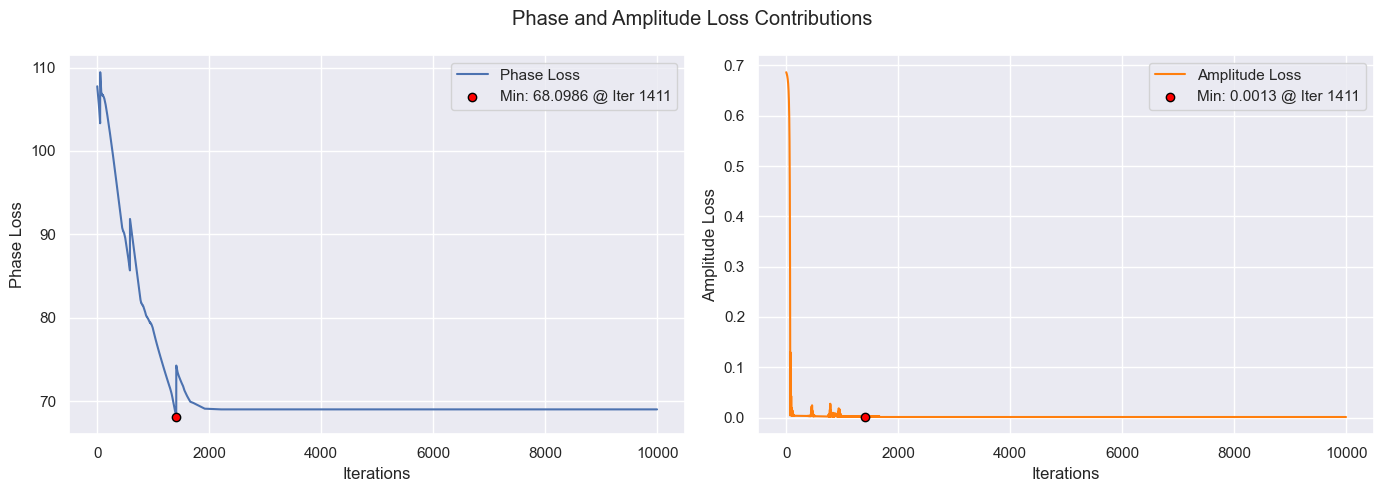

In [16]:
plot_loss_contributions(model.phase_loss_history, model.abs_loss_history)

In [17]:
optimal_complex_n = model.best_params['n'] + 1j*model.best_params['k']

optimal_complex_n

(3.427647352218628-6.628834398725303e-06j)

In [18]:
optimal_H = H_th_function(optimal_complex_n, w=w_tensor, length=3*1e-3)

# Split predictions into components
optimal_abs = torch.abs(optimal_H)
optimal_phase = torch.angle(optimal_H)

# Unwrap phase
optimal_phi = np.unwrap(optimal_phase.numpy())
# Convert back to torch
optimal_phi = torch.tensor(optimal_phi, dtype=torch.float32)

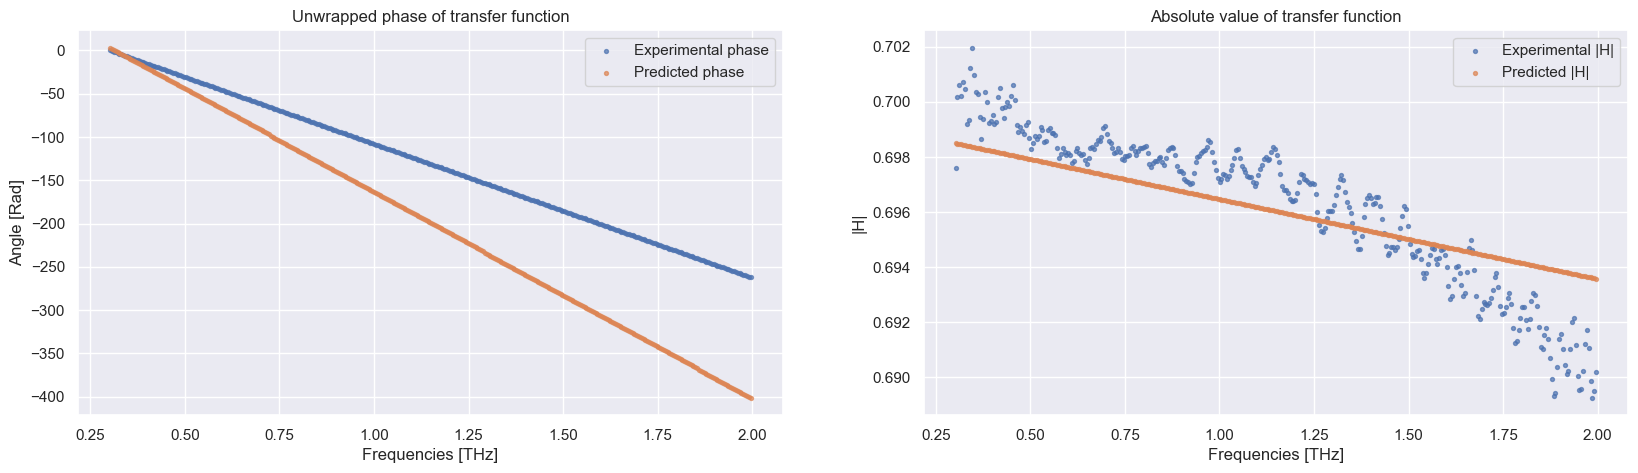

In [19]:
# Plot comparison of experimental data and transfer function with optimized parameters
plot_comparison(freqs_THz, H_values, phi_values, optimal_abs, optimal_phi)